In [ ]:
import pandas as pd

df = pd.read_pickle('longevity/pubmed_longevity.pkl')

In [2]:
import string
import ast

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH

from textsemantics import specific_words
from utils.cluster_utils import find_cluster_words

import numpy as np
from umap import UMAP
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Markdown, display

In [3]:
%%time
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]

        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed


abstracts = list(df['abstract'])
tokens_list = preprocess(abstracts)
texts = [' '.join(t) for t in tokens_list if len(t) > 0]
doc_embs, word_embs, _, _ = specific_words.prepare_embeddings(tokens_list, 'en')

2021-03-25 18:45:31,360 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-03-25 18:45:32,624 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-03-25 18:45:34,579 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-03-25 18:45:35,224 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-03-25 18:45:35,350 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-03-25 18:45:36,687 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-03-25 18:45:38,821 Warning: An empty Sentence was created! Are there empty strings in your dataset?
CPU times: user 1min 46s, sys: 4.21 s, total: 1min 50s
Wall time: 1min 51s


Number of clusters: 6, Noise: 4


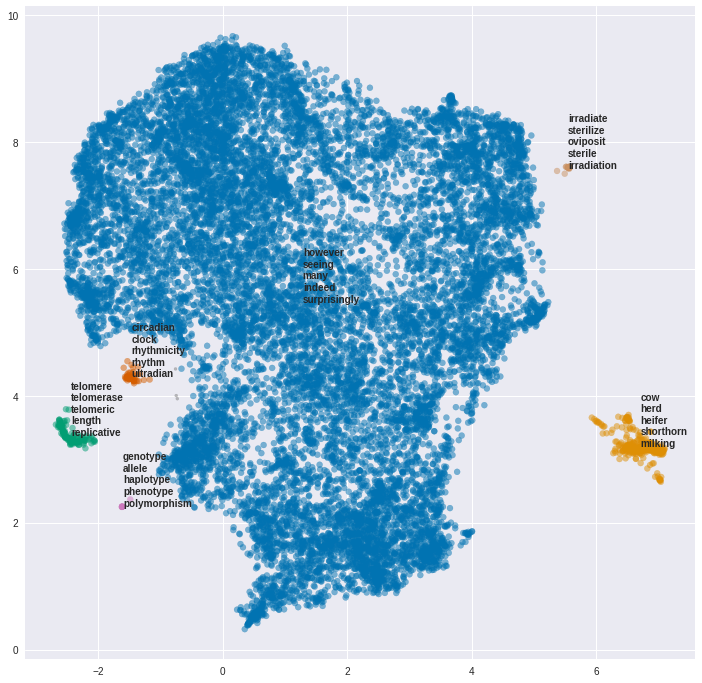

In [4]:
plt.figure(figsize=(12, 12))
plt.style.use('seaborn')

umap = UMAP(random_state=0).fit(doc_embs)

dbscan = DBSCAN(eps=0.2).fit(umap.embedding_)
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
palette = sns.color_palette('colorblind', n_clusters)
print(f"Number of clusters: {n_clusters}, Noise: {n_noise}")


cluster_describer = find_cluster_words(doc_embs, word_embs, dbscan.labels_)

cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in dbscan.labels_]
s = [36 if l > -1 else 9 for l in dbscan.labels_]
plt.scatter(umap.embedding_[:, 0], umap.embedding_[:, 1], c=cs,
            alpha=0.5, s=s);

for cluster, words in cluster_describer.items():
    centroid = np.mean(umap.embedding_[np.where(labels == cluster)[0], :], axis=0)
    ann = "\n".join(cluster_describer[cluster][:5])
    plt.text(centroid[0], centroid[1], ann, fontdict={'fontweight': 'bold'})


In [5]:
md = ''
for cluster, desc in cluster_describer.items():
    docs = np.where(labels == cluster)[0]
    negative = np.where(labels != cluster)[0]
    titles = df['title'].iloc[negative]

    idx = list()
    for kw in desc[:10]:
        idx.extend(t for t in titles if kw in t)

    other = len(set(idx))
    md += f'\n## Cluster {cluster}  - {len(docs)} documents \n'
    md += f'### Keywords: {", ".join(desc[:10])}\n'
    md += f'#### Keywords in titles of other clusters: {other}\n'
    
    for doc in docs[:10]:
        md += f"- {df['title'].iloc[doc]}\n"

display(Markdown(md))


## Cluster 0  - 16264 documents 
### Keywords: however, seeing, many, indeed, surprisingly, yet, nevertheless, potentially, following, seemingly
#### Keywords in titles of other clusters: 4
- The practice of self-preserving behavior of the citizen of the Russian Federation: the results of the All-Russian sociological study "The demographic self-feeling of Russia"
- Efficacy, longevity, and bleaching sensitivity of carbamide and hydrogen peroxides for in-office bleaching: A 6-month randomized, double blind, split-mouth clinical trial.
- Consumption of field-realistic doses of a widely used mito-toxic fungicide reduces thorax mass but does not negatively impact flight capacities of the honey bee (Apis mellifera).
- Calcium channel ITPR2 and mitochondria-ER contacts promote cellular senescence and aging.
- Analysis of distribution characteristics and influencing factors of healthy and long-lived people in Shanglin area of Nanning, Guangxi Zhuang Autonomous Region
- The study on the distribution characteristics and relevant factors of healthy and long-lived people in multiple regions of Guangxi Zhuang Autonomous Region
- SVIP is a molecular determinant of lysosomal dynamic stability, neurodegeneration and lifespan.
- Casein-maltodextrin Maillard conjugates encapsulation enhances the antioxidative potential of proanthocyanidins: An in vitro and in vivo evaluation.
- Aging and Senescence across Reproductive Traits and Survival in Superb Fairy-Wrens (Malurus cyaneus).
- Steroid hormones sulfatase inactivation extends lifespan and ameliorates age-related diseases.

## Cluster 1  - 315 documents 
### Keywords: cow, herd, heifer, shorthorn, milking, calf, dairy, cattle, milker, pasture
#### Keywords in titles of other clusters: 26
- Comparison of performance of F1 Romanov crossbred ewes with wool and hair breeds during fall lambing and body weight and longevity through six production years.
- Invited review: Academic and applied approach to evaluating longevity in dairy cows.
- Changes in milk lactose content as indicators for longevity and udder health in Holstein cows.
- An index framework founded on the future profit potential of female beef cattle to aid the identification of candidates for culling.
- Apgar score or birthweight in Chihuahua dogs born by elective Caesarean section: which is the best predictor of the survival at 24 h after birth?
- Genetic associations between stayability and longevity in commercial crossbred sows, and stayability in multiplier sows.
- Culling reasons and risk factors in Estonian dairy cows.
- Productive life span and resilience rank can be predicted from on-farm first-parity sensor time series but not using a common equation across farms.
- Body weight of dairy heifers is positively associated with reproduction and stayability.
- Symposium review: Why revisit dairy cattle productive lifespan?

## Cluster 2  - 128 documents 
### Keywords: telomere, telomerase, telomeric, length, replicative, microtubule, cohesin, shortening, titin, senescence
#### Keywords in titles of other clusters: 391
- Stress-related changes in leukocyte profiles and telomere shortening in the shortest-lived tetrapod, Furcifer labordi.
- Born to be young? Prenatal thyroid hormones increase early-life telomere length in wild collared flycatchers.
- Mathematical Connection between Short Telomere Induced Senescence Calculation and Mortality Rate Data.
- Exploiting the telomere machinery to put the brakes on inflamm-aging.
- Mice with hyper-long telomeres show less metabolic aging and longer lifespans.
- Individual variation in early-life telomere length and survival in a wild mammal.
- Telomere shortening rate predicts species life span.
- Telomeres and Longevity: A Cause or an Effect?
- Do Telomeres Influence Pace-of-Life-Strategies in Response to Environmental Conditions Over a Lifetime and Between Generations?
- Alcohol consumption and leukocyte telomere length.

## Cluster 3  - 52 documents 
### Keywords: circadian, clock, rhythmicity, rhythm, ultradian, timekeeping, desynchronization, chronobiology, clockwork, rhythmic
#### Keywords in titles of other clusters: 56
- Resetting the Aging Clock: Implications for Managing Age-Related Diseases.
- Chronic circadian misalignment accelerates immune senescence and abbreviates lifespan in mice.
- Circadian gene variants and the skeletal muscle circadian clock contribute to the evolutionary divergence in longevity across Drosophila populations.
- Lifespan is unaffected by size and direction of daily phase shifts in Nasonia, a hymenopteran insect with strong circadian light resetting.
- Effects of MUL1 and PARKIN on the circadian clock, brain and behaviour in Drosophila Parkinson's disease models.
- Circadian clock genes' overexpression in Drosophila alters diet impact on lifespan.
- Rhythms of life: circadian disruption and brain disorders across the lifespan.
- Neuron-specific overexpression of core clock genes improves stress-resistance and extends lifespan of Drosophila melanogaster.
- Clock gene expression and locomotor activity predict death in the last days of life in Drosophila melanogaster.
- Circadian regulation of metabolism and healthspan in Drosophila.

## Cluster 4  - 8 documents 
### Keywords: genotype, allele, haplotype, phenotype, polymorphism, homozygosity, homozygote, multilocus, penetrance, immunogenetic
#### Keywords in titles of other clusters: 451
- The Science of Choosing Wisely: should it be applied to any intervention for healthy and active longevity?
- Lifespan of New Zealand Second World War veterans from one large cemetery: the case for a national-level study.
- Increased synthesis of a coenzyme linked to longevity can combat disease.
- Response to the letter sent by Dr. Viroj Wiwanitkit entitled "Coffee waste, vector control and dengue".
- Coffee waste, vector control, and dengue.
- Health challenges and perspectives for sub-Saharan Africa.
- Lithium treatment and mechanisms of aging.
- Clinical and genetic characteristics of long-livers in Moscow region

## Cluster 5  - 20 documents 
### Keywords: irradiate, sterilize, oviposit, sterile, irradiation, impregnate, medfly, female, inseminate, anaesthetise
#### Keywords in titles of other clusters: 392
- Combined sterile insect technique and incompatible insect technique: sex separation and quality of sterile Aedes aegypti male mosquitoes released in a pilot population suppression trial in Thailand.
- Effect of Gamma Irradiation on Fecundity, Sterility, and Female Sex Pheromone Production of Callosobruchus chinensis (Coleoptera: Bruchidae).
- Effects of Irradiation Dose on Sperm Production, Insemination, and Male Mating Possible Period in the Sweetpotato Weevil (Coleoptera: Brentidae).
- Sexual Competitiveness, Field Survival, and Dispersal of Anastrepha obliqua (Diptera: Tephritidae) Fruit Flies Irradiated at Different Doses.
- Irradiation biology of male brown marmorated stink bugs: is there scope for the sterile insect technique?
- The sterile insect technique for the management of the spotted wing drosophila, Drosophila suzukii: Establishing the optimum irradiation dose.
- Laboratory longevity and competitiveness of Dacus ciliatus Loew (Diptera: Tephritidae) following sub-sterilizing gamma irradiation.
- X-ray-induced sterility in Aedes albopictus (Diptera: Culicidae) and male longevity following irradiation.
- Evaluating irradiation dose for sterility induction and quality control of mass-produced fruit fly Bactrocera tryoni (Diptera: Tephritidae).
- Effects of radiation on inherited sterility in the European grapevine moth (Lobesia botrana).
